## 1) Install & Import libraries

In [1]:
!pip install -q git+https://github.com/roboflow/sports.git


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from inference import get_model
import json
from tqdm import tqdm
import supervision as sv
import os
import numpy as np
import cv2

os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"]="[CUDAExecutionProvider]"

[09/24/24 06:35:56] WARNING  Your inference package version 0.19.0 is out of date! Please upgrade to ]8;id=277937;file://c:\users\borna\pycharmprojects\reinforcedlearning\venv\lib\site-packages\inference\core\__init__.py\__init__.py]8;;\:]8;id=540268;file://c:\users\borna\pycharmprojects\reinforcedlearning\venv\lib\site-packages\inference\core\__init__.py#41\41]8;;\
                             version 0.20.0 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [8]:
!pip install --upgrade inference

  Using cached onnxruntime-1.15.1-cp39-cp39-win_amd64.whl.metadata (4.1 kB)

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\users\\borna\\pycharmprojects\\reinforcedlearning\\venv\\Lib\\site-packages\\onnxruntime\\capi\\onnxruntime_providers_shared.dll'
Check the permissions.


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



   -------------------------------------- 681.1/681.1 kB 660.9 kB/s eta 0:00:00
Using cached onnxruntime-1.15.1-cp39-cp39-win_amd64.whl (6.7 MB)


## 2) Define Input Variables

In [3]:
INPUT_VIDEO_PATH = '08fd33_4.mp4'
OUTPUT_VIDEO_PATH = '08fd33_4_PROC_1.mp4'
BALL_ID = 0
PLAYER_ID = 2
GOALKEEPER_ID = 1

## 3) Download player detection model, for this needed to store your Roboflow credentials into roboflow_creds.json

In [4]:
f = open('roboflow_creds.json') # PLEASE ADD YOUR OWN API KEY TO THIS FILE
creds = json.load(f)

PLAYER_DETECTION_MODEL_ID = "football-players-detection-3zvbc/11"
PLAYER_DETECTION_MODEL = get_model(
    model_id=PLAYER_DETECTION_MODEL_ID,
    api_key=creds['ROBOFLOW_KEY']
)

## 4) Player detection inference

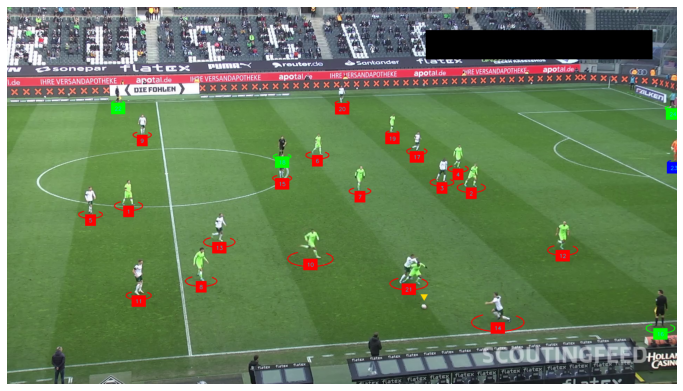

In [43]:
tracker = sv.ByteTrack()
tracker.reset()

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#0000ff', '#ff0000', '#00ff00'])
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#0000ff', '#ff0000', '#00ff00']),
    text_color=sv.Color.from_hex('#ffd700'),
    text_position=sv.Position.BOTTOM_CENTER
)


triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#ffd700'), base=20, height=17
)
frame_generator = sv.get_video_frames_generator(INPUT_VIDEO_PATH)

frame = next(frame_generator)
result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id==BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

people_detections = detections[detections.class_id!=BALL_ID]
people_detections = people_detections.with_nms(threshold=0.5,class_agnostic=True)
people_detections.class_id = people_detections.class_id - 1
people_detections = tracker.update_with_detections(people_detections)

labels = [f"{tracker_id}" for tracker_id in people_detections.tracker_id]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(annotated_frame, people_detections)
annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)
annotated_frame = label_annotator.annotate(annotated_frame, people_detections, labels)

sv.plot_image(annotated_frame)

## Step 5: Assign player to teams

In [9]:
STRIDE = 30

def extract_crops(INPUT_VIDEO_PATH):

    frame_generator = sv.get_video_frames_generator(INPUT_VIDEO_PATH, stride=STRIDE)

    crops = []
    for frame in tqdm(frame_generator, desc='collecting crops'):
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)              
        detections = detections.with_nms(threshold=0.5,class_agnostic=True)
        player_detections = detections[detections.class_id==PLAYER_ID]   
        crops += [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    
    return crops

def assign_goalkeeper_to_team(players_detections: sv.Detections, goalkeepers_detections: sv.Detections):
    
    goalkeepers_xy = goalkeepers_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    
    team_0_center = players_xy[players_detections.class_id==0].mean(axis=0)
    team_1_center = players_xy[players_detections.class_id!=0].mean(axis=0)
    
    goalkeepers_team_ids = []
    
    for xy in goalkeepers_xy:
        
        dist_0 = np.linalg.norm(xy - team_0_center)
        dist_1 = np.linalg.norm(xy - team_1_center)
        
        goalkeepers_team_ids.append(1 if dist_0 > dist_1 else 0)
    
    return np.array(goalkeepers_team_ids)

In [10]:
from sports.common.team import TeamClassifier

crops = extract_crops(INPUT_VIDEO_PATH)

collecting crops: 25it [00:15,  1.60it/s]


In [11]:
team_classifier = TeamClassifier(device='cuda')
team_classifier.fit(crops)

Embedding extraction: 0it [00:00, ?it/s]UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
Embedding extraction: 19it [00:15,  1.24it/s]


Embedding extraction: 1it [00:00,  2.00it/s]


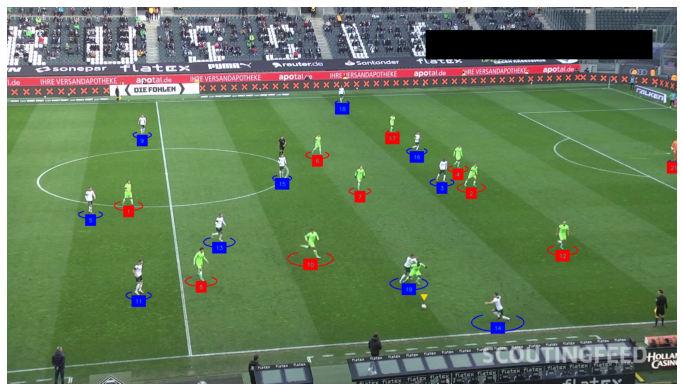

In [30]:
tracker = sv.ByteTrack()
tracker.reset()

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#0000ff', '#ff0000', '#00ff00'])
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#0000ff', '#ff0000', '#00ff00']),
    text_color=sv.Color.from_hex('#ffd700'),
    text_position=sv.Position.BOTTOM_CENTER
)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#ffd700'), base=20, height=17
)

frame_generator = sv.get_video_frames_generator(INPUT_VIDEO_PATH)

frame = next(frame_generator)
result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id==BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

player_detections = detections[detections.class_id==PLAYER_ID]
player_crops =  [sv.crop_image(frame, xyxy) for xyxy in player_detections.xyxy]
player_detections.class_id = team_classifier.predict(player_crops)

goalkeeper_detections = detections[detections.class_id==GOALKEEPER_ID]
goalkeeper_detections.class_id = assign_goalkeeper_to_team(player_detections, goalkeeper_detections)

team_detections = sv.Detections.merge([player_detections,goalkeeper_detections])

team_detections = tracker.update_with_detections(team_detections)

labels = [f"{tracker_id}" for tracker_id in team_detections.tracker_id]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(annotated_frame, team_detections)
annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)
annotated_frame = label_annotator.annotate(annotated_frame, team_detections, labels)

sv.plot_image(annotated_frame)

## 6) Download keypoint detection model from roboflow

In [15]:
PITCH_DETECTION_MODEL_ID = "football-field-detection-f07vi/14"
PITCH_DETECTION_MODEL = get_model(
    model_id=PITCH_DETECTION_MODEL_ID,
    api_key=creds['ROBOFLOW_KEY']
)

## 7) Keypoint detection inference

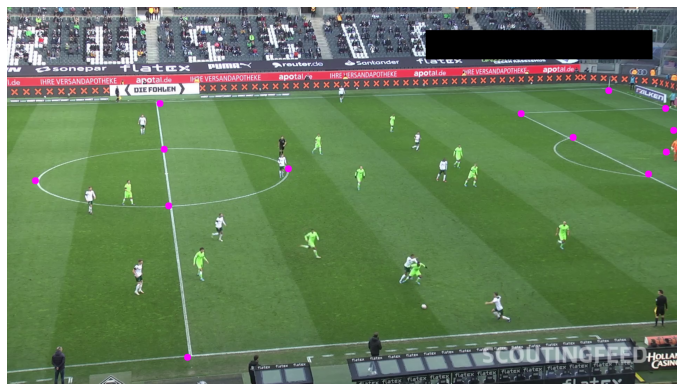

In [25]:

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#ff00ff'), radius=10
)

min_key_points_conf = 0.5

frame_generator = sv.get_video_frames_generator(INPUT_VIDEO_PATH)

frame = next(frame_generator)
result = PITCH_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

key_points_filter = key_points.confidence[0]>min_key_points_conf
filtered_key_points_xy = key_points.xy[0][key_points_filter]
filtered_key_points = sv.KeyPoints(xy=filtered_key_points_xy[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(annotated_frame, filtered_key_points)

sv.plot_image(annotated_frame)

## 8) Projection of key points on the frame and back

In [12]:
class ViewTransformer:
    
    def __init__(self, source: np.ndarray, target: np.ndarray):
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.homography, _ = cv2.findHomography(source,target)
        
    def transform_points(self, points: np.ndarray) -> np.ndarray:
        
        points = points.reshape(-1,1,2).astype(np.float32)
        points = cv2.perspectiveTransform(points,self.homography)
        
        return points.reshape(-1,2).astype(np.float32)

In [13]:
from sports.configs.soccer import SoccerPitchConfiguration
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch

CONFIG = SoccerPitchConfiguration()

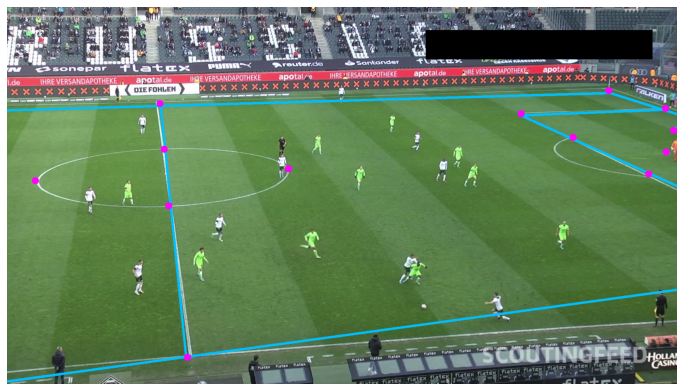

In [56]:
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#ff00ff'), radius=10
)

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00bfff'),
    thickness=5,
    edges=CONFIG.edges
)

min_key_points_conf = 0.5

frame_generator = sv.get_video_frames_generator(INPUT_VIDEO_PATH)
frame = next(frame_generator)

result = PITCH_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

key_points_filter = key_points.confidence[0]>min_key_points_conf
filtered_key_points_xy = key_points.xy[0][key_points_filter]
filtered_ref_key_points = sv.KeyPoints(xy=filtered_key_points_xy[np.newaxis, ...])
pitch_ref_points = np.array(CONFIG.vertices)[key_points_filter]

view_transformer = ViewTransformer(source=pitch_ref_points, target=filtered_key_points_xy)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = view_transformer.transform_points(pitch_all_points)
frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(annotated_frame, frame_all_key_points)
annotated_frame = vertex_annotator.annotate(annotated_frame, filtered_ref_key_points)

sv.plot_image(annotated_frame)

## 9) Merging it all together

Embedding extraction: 1it [00:00,  1.93it/s]


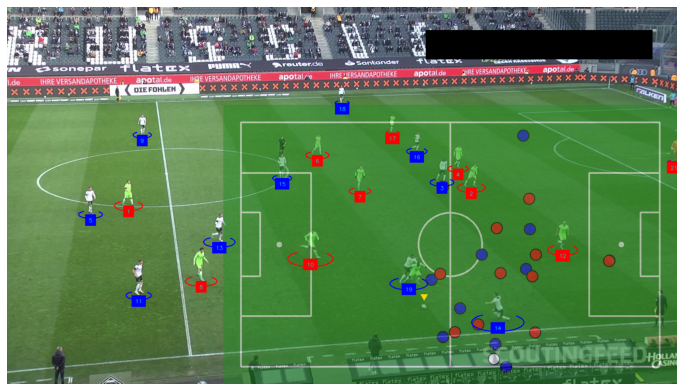

In [17]:
tracker = sv.ByteTrack()
tracker.reset()

min_key_points_conf = 0.5

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#0000ff', '#ff0000', '#00ff00'])
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#0000ff', '#ff0000', '#00ff00']),
    text_color=sv.Color.from_hex('#ffd700'),
    text_position=sv.Position.BOTTOM_CENTER
)


triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#ffd700'), base=20, height=17
)

frame_generator = sv.get_video_frames_generator(INPUT_VIDEO_PATH)

frame = next(frame_generator)
player_detection_inference = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(player_detection_inference)

ball_detections = detections[detections.class_id==BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

player_detections = detections[detections.class_id==PLAYER_ID]
player_crops =  [sv.crop_image(frame, xyxy) for xyxy in player_detections.xyxy]
player_detections.class_id = team_classifier.predict(player_crops)

goalkeeper_detections = detections[detections.class_id==GOALKEEPER_ID]
goalkeeper_detections.class_id = assign_goalkeeper_to_team(player_detections, goalkeeper_detections)

team_detections = sv.Detections.merge([player_detections,goalkeeper_detections])

team_detections = tracker.update_with_detections(team_detections)

labels = [f"{tracker_id}" for tracker_id in team_detections.tracker_id]

key_points_detection_inference = PITCH_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(key_points_detection_inference)

key_points_filter = key_points.confidence[0]>min_key_points_conf
filtered_key_points_xy = key_points.xy[0][key_points_filter]
filtered_ref_key_points = sv.KeyPoints(xy=filtered_key_points_xy[np.newaxis, ...])
pitch_ref_points = np.array(CONFIG.vertices)[key_points_filter]

view_transformer = ViewTransformer(source=filtered_key_points_xy, target=pitch_ref_points)

frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)

frame_people_xy = team_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_people_xy = view_transformer.transform_points(frame_people_xy)

annotated_frame = frame.copy()

# Add pitch as overlay
pitch = draw_pitch(CONFIG)
pitch = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=pitch)
pitch = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_people_xy[team_detections.class_id==0],
    face_color=sv.Color.BLUE,
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=pitch)
pitch = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_people_xy[team_detections.class_id==1],
    face_color=sv.Color.RED,
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=pitch)

overlay_x = [annotated_frame.shape[0] - pitch.shape[0],annotated_frame.shape[0]]
overlay_y = [annotated_frame.shape[1] - pitch.shape[1],annotated_frame.shape[1]]

overlay = frame.copy()
overlay[overlay_x[0]:overlay_x[1],overlay_y[0]:overlay_y[1],:] = pitch

alpha = 0.5
cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, annotated_frame)

annotated_frame = ellipse_annotator.annotate(annotated_frame, team_detections)
annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)
annotated_frame = label_annotator.annotate(annotated_frame, team_detections, labels)

# Plot final image
sv.plot_image(annotated_frame)

## 10) Process all frames from first 20 seconds of the video

In [19]:
video_info = sv.VideoInfo.from_video_path(INPUT_VIDEO_PATH)
video_sink = sv.VideoSink(OUTPUT_VIDEO_PATH, video_info=video_info)

frame_generator = sv.get_video_frames_generator(INPUT_VIDEO_PATH)

frame_max = 480
frame_num = 0

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        
        #Processing only first 240 images
        frame_num = frame_num + 1
        if frame_num > frame_max:
            break
        #get detections
        player_detection_inference = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(player_detection_inference)

        ball_detections = detections[detections.class_id==BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        player_detections = detections[detections.class_id==PLAYER_ID]
        player_crops =  [sv.crop_image(frame, xyxy) for xyxy in player_detections.xyxy]
        player_detections.class_id = team_classifier.predict(player_crops)

        goalkeeper_detections = detections[detections.class_id==GOALKEEPER_ID]
        goalkeeper_detections.class_id = assign_goalkeeper_to_team(player_detections, goalkeeper_detections)

        team_detections = sv.Detections.merge([player_detections,goalkeeper_detections])
        team_detections = tracker.update_with_detections(team_detections)
        labels = [f"{tracker_id}" for tracker_id in team_detections.tracker_id]
        
        # Add output frame 
        annotated_frame = frame.copy()

        # Add Pitch Step 1: calulate transformations
        key_points_detection_inference = PITCH_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        key_points = sv.KeyPoints.from_inference(key_points_detection_inference)

        key_points_filter = key_points.confidence[0]>min_key_points_conf
        filtered_key_points_xy = key_points.xy[0][key_points_filter]
        filtered_ref_key_points = sv.KeyPoints(xy=filtered_key_points_xy[np.newaxis, ...])
        pitch_ref_points = np.array(CONFIG.vertices)[key_points_filter]

        view_transformer = ViewTransformer(source=filtered_key_points_xy, target=pitch_ref_points)
        
        frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        
        if len(frame_ball_xy)==0:
            pitch_ball_xy = last_pitch_ball_xy
        else:
            pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)
            last_pitch_ball_xy = pitch_ball_xy

        frame_people_xy = team_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        pitch_people_xy = view_transformer.transform_points(frame_people_xy)
        
        # Add Pitch Step 2: add objects to pitch
        pitch = draw_pitch(CONFIG)
        pitch = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_ball_xy,
            face_color=sv.Color.WHITE,
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=pitch)
        pitch = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_people_xy[team_detections.class_id==0],
            face_color=sv.Color.BLUE,
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=pitch)
        pitch = draw_points_on_pitch(
            config=CONFIG,
            xy=pitch_people_xy[team_detections.class_id==1],
            face_color=sv.Color.RED,
            edge_color=sv.Color.BLACK,
            radius=16,
            pitch=pitch)

        # add pitch as overlay to frame
        overlay_x = [annotated_frame.shape[0] - pitch.shape[0],annotated_frame.shape[0]]
        overlay_y = [annotated_frame.shape[1] - pitch.shape[1],annotated_frame.shape[1]]

        overlay = frame.copy()
        overlay[overlay_x[0]:overlay_x[1],overlay_y[0]:overlay_y[1],:] = pitch

        alpha = 0.5
        cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, annotated_frame)
        
        # Add annotations to frame
        annotated_frame = ellipse_annotator.annotate(annotated_frame, team_detections)
        annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)
        annotated_frame = label_annotator.annotate(annotated_frame, team_detections, labels)
        
        # add frame to output
        video_sink.write_frame(annotated_frame)

  0%|                                                                                                                                                           | 0/750 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.99it/s]
  0%|▏                                                                                                                                                  | 1/750 [00:04<54:46,  4.39s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.99it/s]
  0%|▍                                                                                                                                                  | 2/750 [00:08<52:27,  4.21s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.93it/s]
  0%|▌                                                                                                                                                  | 3/750 [00:12<53:01,  4.26s/it]
Em

  4%|█████▌                                                                                                                                          | 29/750 [02:32<1:15:33,  6.29s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.59it/s]
  4%|█████▊                                                                                                                                          | 30/750 [02:38<1:15:29,  6.29s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.19it/s]
  4%|█████▉                                                                                                                                          | 31/750 [02:44<1:15:27,  6.30s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.25it/s]
  4%|██████▏                                                                                                                                         | 32/750 [02:50<1:13:58,  6.18s/it]
Em

  8%|███████████▏                                                                                                                                    | 58/750 [06:23<1:53:23,  9.83s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.63it/s]
  8%|███████████▎                                                                                                                                    | 59/750 [06:30<1:43:37,  9.00s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.10it/s]
  8%|███████████▌                                                                                                                                    | 60/750 [06:40<1:46:04,  9.22s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.62it/s]
  8%|███████████▋                                                                                                                                    | 61/750 [06:46<1:36:39,  8.42s/it]
Em

 12%|████████████████▋                                                                                                                               | 87/750 [10:02<1:37:59,  8.87s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.20it/s]
 12%|████████████████▉                                                                                                                               | 88/750 [10:15<1:50:37, 10.03s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.25it/s]
 12%|█████████████████                                                                                                                               | 89/750 [10:22<1:40:27,  9.12s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.27it/s]
 12%|█████████████████▎                                                                                                                              | 90/750 [10:33<1:47:36,  9.78s/it]
Em

 15%|██████████████████████                                                                                                                         | 116/750 [15:12<1:57:20, 11.10s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.45it/s]
 16%|██████████████████████▎                                                                                                                        | 117/750 [15:27<2:10:53, 12.41s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.50it/s]
 16%|██████████████████████▍                                                                                                                        | 118/750 [15:34<1:52:54, 10.72s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.11it/s]
 16%|██████████████████████▋                                                                                                                        | 119/750 [15:49<2:06:57, 12.07s/it]
Em

 19%|███████████████████████████▋                                                                                                                   | 145/750 [20:28<1:52:33, 11.16s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.22it/s]
 19%|███████████████████████████▊                                                                                                                   | 146/750 [20:40<1:56:50, 11.61s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.43it/s]
 20%|████████████████████████████                                                                                                                   | 147/750 [20:48<1:44:31, 10.40s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.31it/s]
 20%|████████████████████████████▏                                                                                                                  | 148/750 [21:04<2:00:37, 12.02s/it]
Em

 23%|█████████████████████████████████▏                                                                                                             | 174/750 [27:19<2:23:22, 14.94s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.07it/s]
 23%|█████████████████████████████████▎                                                                                                             | 175/750 [27:39<2:37:20, 16.42s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.14it/s]
 23%|█████████████████████████████████▌                                                                                                             | 176/750 [27:52<2:28:58, 15.57s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.27it/s]
 24%|█████████████████████████████████▋                                                                                                             | 177/750 [28:05<2:21:32, 14.82s/it]
Em

 27%|██████████████████████████████████████▋                                                                                                        | 203/750 [33:30<1:25:21,  9.36s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.17it/s]
 27%|██████████████████████████████████████▉                                                                                                        | 204/750 [33:39<1:24:39,  9.30s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.17it/s]
 27%|███████████████████████████████████████                                                                                                        | 205/750 [33:51<1:31:25, 10.06s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.17it/s]
 27%|███████████████████████████████████████▎                                                                                                       | 206/750 [34:03<1:38:21, 10.85s/it]
Em

 31%|████████████████████████████████████████████▏                                                                                                  | 232/750 [40:15<2:14:58, 15.63s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.06it/s]
 31%|████████████████████████████████████████████▍                                                                                                  | 233/750 [40:35<2:25:48, 16.92s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.05it/s]
 31%|████████████████████████████████████████████▌                                                                                                  | 234/750 [40:51<2:22:32, 16.57s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.36it/s]
 31%|████████████████████████████████████████████▊                                                                                                  | 235/750 [41:07<2:21:37, 16.50s/it]
Em

 35%|█████████████████████████████████████████████████▊                                                                                             | 261/750 [46:54<1:51:38, 13.70s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.20it/s]
 35%|█████████████████████████████████████████████████▉                                                                                             | 262/750 [47:08<1:50:41, 13.61s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.47it/s]
 35%|██████████████████████████████████████████████████▏                                                                                            | 263/750 [47:20<1:48:36, 13.38s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.22it/s]
 35%|██████████████████████████████████████████████████▎                                                                                            | 264/750 [47:34<1:48:13, 13.36s/it]
Em

 39%|███████████████████████████████████████████████████████▎                                                                                       | 290/750 [52:23<1:21:58, 10.69s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.60it/s]
 39%|███████████████████████████████████████████████████████▍                                                                                       | 291/750 [52:30<1:12:24,  9.46s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.30it/s]
 39%|███████████████████████████████████████████████████████▋                                                                                       | 292/750 [52:42<1:19:51, 10.46s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.63it/s]
 39%|███████████████████████████████████████████████████████▊                                                                                       | 293/750 [52:52<1:17:54, 10.23s/it]
Em

 43%|████████████████████████████████████████████████████████████▊                                                                                  | 319/750 [57:24<1:22:23, 11.47s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.10it/s]
 43%|█████████████████████████████████████████████████████████████                                                                                  | 320/750 [57:37<1:26:03, 12.01s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.34it/s]
 43%|█████████████████████████████████████████████████████████████▏                                                                                 | 321/750 [57:46<1:19:30, 11.12s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.18it/s]
 43%|█████████████████████████████████████████████████████████████▍                                                                                 | 322/750 [57:53<1:10:37,  9.90s/it]
Em

 46%|█████████████████████████████████████████████████████████████████▍                                                                           | 348/750 [1:02:34<1:05:18,  9.75s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.40it/s]
 47%|██████████████████████████████████████████████████████████████████▌                                                                            | 349/750 [1:02:41<59:52,  8.96s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.28it/s]
 47%|█████████████████████████████████████████████████████████████████▊                                                                           | 350/750 [1:02:54<1:08:42, 10.31s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.26it/s]
 47%|█████████████████████████████████████████████████████████████████▉                                                                           | 351/750 [1:03:06<1:11:22, 10.73s/it]
Em

 50%|███████████████████████████████████████████████████████████████████████▉                                                                       | 377/750 [1:06:53<52:18,  8.41s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.35it/s]
 50%|████████████████████████████████████████████████████████████████████████                                                                       | 378/750 [1:07:02<53:44,  8.67s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.32it/s]
 51%|████████████████████████████████████████████████████████████████████████▎                                                                      | 379/750 [1:07:11<53:52,  8.71s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.28it/s]
 51%|████████████████████████████████████████████████████████████████████████▍                                                                      | 380/750 [1:07:19<51:57,  8.43s/it]
Em

 54%|█████████████████████████████████████████████████████████████████████████████▍                                                                 | 406/750 [1:11:30<54:04,  9.43s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.32it/s]
 54%|█████████████████████████████████████████████████████████████████████████████▌                                                                 | 407/750 [1:11:43<59:30, 10.41s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.52it/s]
 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                 | 408/750 [1:11:51<55:19,  9.71s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.30it/s]
 55%|█████████████████████████████████████████████████████████████████████████████▉                                                                 | 409/750 [1:12:02<58:16, 10.25s/it]
Em

 58%|██████████████████████████████████████████████████████████████████████████████████▉                                                            | 435/750 [1:16:00<47:49,  9.11s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.20it/s]
 58%|███████████████████████████████████████████████████████████████████████████████████▏                                                           | 436/750 [1:16:11<50:16,  9.61s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.49it/s]
 58%|███████████████████████████████████████████████████████████████████████████████████▎                                                           | 437/750 [1:16:18<46:42,  8.95s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.19it/s]
 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                           | 438/750 [1:16:32<53:50, 10.35s/it]
Em

 62%|████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 464/750 [1:20:30<44:21,  9.30s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.22it/s]
 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 465/750 [1:20:38<42:49,  9.01s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.23it/s]
 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 466/750 [1:20:46<40:14,  8.50s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  1.46it/s]
 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                      | 467/750 [1:20:53<38:58,  8.26s/it]
Em